# Shoreline Change Extraction using Band Ratio

In [1]:
import planetary_computer as pc
import pystac_client
from pystac.extensions.projection import ProjectionExtension as proj
import stackstac

import numpy as np
import xarray as xr
import os

import matplotlib.pyplot as plt
import geopandas as gpd
import json

from shapely.geometry import shape
import rioxarray
from rasterio.crs import CRS
from rasterio.plot import show
import rasterio.features

from dask.distributed import Client, progress
import dask

### Dask Cluster

In [2]:
client = Client()
dask.config.set(**{'array.slicing.split_large_chunks': False})
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")


/proxy/8787/status


### Area of Interest

In [3]:
aoi = 'nauru'
local =  gpd.read_file(aoi + '.geojson')
area_of_interest = local.geometry[0]
local.explore()

### Request Multispectal Data (S2 or L8)

In [4]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

search = catalog.search(
    intersects=area_of_interest,
    datetime="2021-01-01/2022-03-30",
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"lt": 1.0}}, #cloudcover_percentage
)

raw_items = search.get_items()

count = 0
for item in raw_items:    
    print(f"{item.id}: {item.datetime} Cloud : {item.properties['eo:cloud_cover']}")
    count = count + 1
print(f"{count} Items")

S2A_MSIL2A_20211120T232621_R044_T58MGE_20211121T075719: 2021-11-20 23:26:21.024000+00:00 Cloud : 0.994915
S2A_MSIL2A_20210812T232621_R044_T58MGE_20210813T052643: 2021-08-12 23:26:21.024000+00:00 Cloud : 0.488811
S2B_MSIL2A_20210129T232619_R044_T58MGE_20210130T100038: 2021-01-29 23:26:19.024000+00:00 Cloud : 0.137471
S2A_MSIL2A_20210124T232621_R044_T58MGE_20210125T053442: 2021-01-24 23:26:21.024000+00:00 Cloud : 0.220703
4 Items


### Sign STAC, Resample (Time, Resolution), Retrieve Bands 

In [5]:
#sort by cloud cover and select first 1
raw_items = search.get_items()
raw_items = sorted(raw_items, key=lambda item: item.properties['eo:cloud_cover'])[0:1]

#sign
items = [pc.sign(item).to_dict() for item in raw_items]

#epsg
item = next(search.get_items())
epsg = proj.ext(item).epsg

data = (
    stackstac.stack(
        items, 
        epsg=epsg,
        #resampling=rasterio.enums.Resampling.bilinear,
        resolution=10, #resolution/m
        assets=["B02", "B04", "B08"],  # blue, green, red, nir
        #assets=["B02", "B03", "B04", "B08"],  # blue, green, red, nir
        chunksize=4096, #8192, #4096, #256,  # set chunk size to 256 to get one chunk per time step
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(
        band=lambda x: x.common_name.rename("band"),  # use common names
        #time=lambda x: x.time.dt.round(
        #    "D"
        #),  # round time to daily for nicer plot labels
    ).persist()
)

#downsample to yearly
#data = data.resample(time="6MS").median("time", keep_attrs=True)
#data = data.resample(time="1Y").median("time", keep_attrs=True)

data

<xarray.DataArray 'stackstac-ce53ec76047923763ec99c2ea92cc570' (time: 1, band: 3, y: 10980, x: 10980)>
dask.array<where, shape=(1, 3, 10980, 10980), dtype=float64, chunksize=(1, 1, 4096, 4096), chunktype=numpy.ndarray>
Coordinates:
  * time                                     (time) datetime64[ns] 2021-01-29...
    id                                       (time) <U54 'S2B_MSIL2A_20210129...
  * band                                     (band) <U4 'blue' 'red' 'nir'
  * x                                        (x) float64 7e+05 ... 8.098e+05
  * y                                        (y) float64 1e+07 ... 9.89e+06
    s2:datatake_id                           <U34 'GS2B_20210129T232619_02037...
    s2:high_proba_clouds_percentage          float64 0.01683
    proj:epsg                                int64 32758
    s2:thin_cirrus_percentage                float64 0.06578
    s2:granule_id                            <U62 'S2B_OPER_MSI_L2A_TL_ESRI_2...
    s2:saturated_defective_pixel_percentage  float64 0.0
    sat:relative_orbit                       int64 44
    s2:vegetation_percentage                 float64 0.262
    s2:cloud_shadow_percentage               float64 0.000951
    s2:not_vegetated_percentage              float64 0.4289
    s2:mgrs_tile                             <U5 '58MGE'
    s2:unclassified_percentage               float64 0.02601
    s2:datatake_type                         <U8 'INS-NOBS'
    s2:product_uri                           <U65 'S2B_MSIL2A_20210129T232619...
    instruments                              <U3 'msi'
    s2:medium_proba_clouds_percentage        float64 0.05487
    s2:degraded_msi_data_percentage          float64 0.0
    constellation                            <U10 'Sentinel 2'
    eo:cloud_cover                           float64 0.1375
    s2:water_percentage                      float64 99.14
    s2:mean_solar_azimuth                    float64 126.9
    s2:dark_features_percentage              float64 0.001585
    s2:generation_time                       <U24 '2021-01-30T10:00:38.792Z'
    sat:orbit_state                          <U10 'descending'
    s2:datastrip_id                          <U64 'S2B_OPER_MSI_L2A_DS_ESRI_2...
    s2:product_type                          <U7 'S2MSI2A'
    s2:mean_solar_zenith                     float64 29.49
    s2:snow_ice_percentage                   float64 0.0
    s2:nodata_pixel_percentage               float64 74.88
    platform                                 <U11 'Sentinel-2B'
    s2:reflectance_conversion_factor         float64 1.032
    s2:processing_baseline                   <U5 '02.12'
    proj:transform                           object {0.0, 10000000.0, 10.0, -...
    proj:shape                               object {10980}
    title                                    (band) <U19 'Band 2 - Blue - 10m...
    gsd                                      int64 10
    proj:bbox                                object {699960.0, 809760.0, 9890...
    common_name                              (band) <U4 'blue' 'red' 'nir'
    center_wavelength                        (band) float64 0.49 0.665 0.842
    full_width_half_max                      (band) float64 0.098 0.038 0.145
    epsg                                     int64 32758
Attributes:
    spec:        RasterSpec(epsg=32758, bounds=(699960, 9890200, 809760, 1000...
    crs:         epsg:32758
    transform:   | 10.00, 0.00, 699960.00|\n| 0.00,-10.00, 10000000.00|\n| 0....
    resolution:  10

In [22]:
import requests
from PIL import Image
from urllib.request import urlopen

#asset = item.assets["visual"] #preview
#requests.get(asset.href)
#signed_href = pc.sign(asset.href)
#print(signed_href)
#Image.open(urlopen(signed_href))

bands = ['B02', 'B03', 'B04'] #blue, green, red
for b in bands:
    asset = item.assets[b] 
    requests.get(asset.href)
    signed_href = pc.sign(asset.href)
    print(b + " : " + signed_href)
    


B02 : https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/58/M/GE/2021/11/20/S2A_MSIL2A_20211120T232621_N0300_R044_T58MGE_20211121T075719.SAFE/GRANULE/L2A_T58MGE_A033503_20211120T232622/IMG_DATA/R10m/T58MGE_20211120T232621_B02_10m.tif?st=2022-04-06T02%3A33%3A59Z&se=2022-04-07T10%3A33%3A59Z&sp=rl&sv=2020-06-12&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-04-07T00%3A00%3A39Z&ske=2022-04-14T00%3A00%3A39Z&sks=b&skv=2020-06-12&sig=pvq4PDeuIVdCodube5MGia95bc0NDESXp7HooynaIqE%3D
B03 : https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/58/M/GE/2021/11/20/S2A_MSIL2A_20211120T232621_N0300_R044_T58MGE_20211121T075719.SAFE/GRANULE/L2A_T58MGE_A033503_20211120T232622/IMG_DATA/R10m/T58MGE_20211120T232621_B03_10m.tif?st=2022-04-06T02%3A33%3A59Z&se=2022-04-07T10%3A33%3A59Z&sp=rl&sv=2020-06-12&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-04-07T00%3A00%3A39Z&ske=2022-04-14T00%3A00%3A

### Reproject

In [7]:
#Ensures the GeoTiff outputs have the default original projection embedded
#data = data.rio.reproject(4326)
print(data.crs)
data.rio.set_crs(data.crs, inplace=True)
data.rio.write_crs(data.crs, inplace=True)


epsg:32758


<xarray.DataArray 'stackstac-ce53ec76047923763ec99c2ea92cc570' (time: 1, band: 3, y: 10980, x: 10980)>
dask.array<where, shape=(1, 3, 10980, 10980), dtype=float64, chunksize=(1, 1, 4096, 4096), chunktype=numpy.ndarray>
Coordinates:
  * time                                     (time) datetime64[ns] 2021-01-29...
    id                                       (time) <U54 'S2B_MSIL2A_20210129...
  * band                                     (band) <U4 'blue' 'red' 'nir'
  * x                                        (x) float64 7e+05 ... 8.098e+05
  * y                                        (y) float64 1e+07 ... 9.89e+06
    s2:datatake_id                           <U34 'GS2B_20210129T232619_02037...
    s2:high_proba_clouds_percentage          float64 0.01683
    proj:epsg                                int64 32758
    s2:thin_cirrus_percentage                float64 0.06578
    s2:granule_id                            <U62 'S2B_OPER_MSI_L2A_TL_ESRI_2...
    s2:saturated_defective_pixel_percentage  float64 0.0
    sat:relative_orbit                       int64 44
    s2:vegetation_percentage                 float64 0.262
    s2:cloud_shadow_percentage               float64 0.000951
    s2:not_vegetated_percentage              float64 0.4289
    s2:mgrs_tile                             <U5 '58MGE'
    s2:unclassified_percentage               float64 0.02601
    s2:datatake_type                         <U8 'INS-NOBS'
    s2:product_uri                           <U65 'S2B_MSIL2A_20210129T232619...
    instruments                              <U3 'msi'
    s2:medium_proba_clouds_percentage        float64 0.05487
    s2:degraded_msi_data_percentage          float64 0.0
    constellation                            <U10 'Sentinel 2'
    eo:cloud_cover                           float64 0.1375
    s2:water_percentage                      float64 99.14
    s2:mean_solar_azimuth                    float64 126.9
    s2:dark_features_percentage              float64 0.001585
    s2:generation_time                       <U24 '2021-01-30T10:00:38.792Z'
    sat:orbit_state                          <U10 'descending'
    s2:datastrip_id                          <U64 'S2B_OPER_MSI_L2A_DS_ESRI_2...
    s2:product_type                          <U7 'S2MSI2A'
    s2:mean_solar_zenith                     float64 29.49
    s2:snow_ice_percentage                   float64 0.0
    s2:nodata_pixel_percentage               float64 74.88
    platform                                 <U11 'Sentinel-2B'
    s2:reflectance_conversion_factor         float64 1.032
    s2:processing_baseline                   <U5 '02.12'
    proj:transform                           object {0.0, 10000000.0, 10.0, -...
    proj:shape                               object {10980}
    title                                    (band) <U19 'Band 2 - Blue - 10m...
    gsd                                      int64 10
    proj:bbox                                object {699960.0, 809760.0, 9890...
    common_name                              (band) <U4 'blue' 'red' 'nir'
    center_wavelength                        (band) float64 0.49 0.665 0.842
    full_width_half_max                      (band) float64 0.098 0.038 0.145
    epsg                                     int64 32758
    spatial_ref                              int64 0
Attributes:
    spec:        RasterSpec(epsg=32758, bounds=(699960, 9890200, 809760, 1000...
    crs:         epsg:32758
    transform:   | 10.00, 0.00, 699960.00|\n| 0.00,-10.00, 10000000.00|\n| 0....
    resolution:  10

### Band Ratio

Band Ratio technique is a efficient method, which gives highly accurate results with less processing time and it is able to cover both temporal and spatial aspects of coastline changes. Band Ratio technique is a easy to calculate method which gives highly accurate results with less processing time. The workflow can be applied on any area using multispectral imagery i.e. Landsat-8, Sentinel-2, etc. A recent remote sensing technique to extract coastline is `Band Ratio`. In this technique the DN values of bands are divided to create a binary raster. NIR, Red and Blue bands were used for creating the binary raster. NIR band is selected as it is able to delineate water-land boundary, Red band is important for vegetation and water content and Blue band has high reflectance in water bodies

In [8]:
blue = data.sel(band="blue") 
red = data.sel(band="red")
nir = data.sel(band="nir")

#ndvi = ((nir - red) / (red + nir)).compute()
br = ((blue > nir) & (blue > red)).compute()

In [9]:
br = br * 255.0 #0 for land, 255 for sea/water

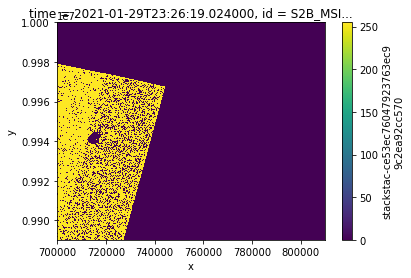

In [10]:

#br[0].plot.imshow()
d = br[0]
d.plot.imshow()


In [11]:
d.rio.to_raster(aoi + ".tif", driver="COG")
#br[0].rio.to_raster("test.tif", driver="COG")

### Clip to AOI

In [12]:
local = local.to_crs(epsg=epsg)
bbox = rasterio.features.bounds(local.geometry[0])
print(bbox)

tin = aoi + ".tif"
out = aoi + "_clipped.tif"

#nauru
!gdal_translate -ot Int16 -projwin 711767.4112323204 9944689.99312122 718391.6272327953 9938280.891166033 -of GTiff $tin $out

#fiji_coral_coast
#!gdal_translate -ot Int16 -projwin 596828.3902 8002621.5619 649022.8146 7973162.5574 -of GTiff $tin $out


(711768.4427966578, 9938282.17441632, 718391.2017987678, 9944688.98744344)
Input file size is 10980, 10980
0...10...20...30...40...50...60...70...80...90...100 - done.


### Vectorise

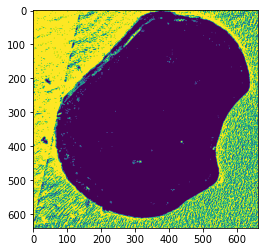

<AxesSubplot:>

In [14]:
with rasterio.open(aoi + '_clipped.tif') as xds:    
    band = xds.read()

show(band)

In [15]:
#Filter Water Band (0)
mask = band != 255
shapes = rasterio.features.shapes(band, mask=mask, transform=xds.transform)

#polygons = gpd.GeoDataFrame.from_features(geoms)
band = []
geometry = []
for shapedict, value in shapes:
    band.append(value)
    geometry.append(shape(shapedict))

# build the gdf object over the two lists
gdf = gpd.GeoDataFrame(
    {'band': band, 'geometry': geometry},
    crs=data.crs
)


In [16]:
gdf

,band,geometry
0,0.0,"POLYGON ((712575.000 9944695.000, 712575.000 9..."
1,0.0,"POLYGON ((713135.000 9944695.000, 713135.000 9..."
2,0.0,"POLYGON ((713495.000 9944695.000, 713495.000 9..."
3,0.0,"POLYGON ((713665.000 9944695.000, 713665.000 9..."
4,0.0,"POLYGON ((713735.000 9944695.000, 713735.000 9..."
...,...,...
7077,0.0,"POLYGON ((717885.000 9938305.000, 717895.000 9..."
7078,0.0,"POLYGON ((717925.000 9938315.000, 717935.000 9..."
7079,0.0,"POLYGON ((718175.000 9938325.000, 718185.000 9..."
7080,0.0,"POLYGON ((718255.000 9938295.000, 718255.000 9..."


### Extract Coastline (Largest Feature Shape Area)

In [17]:
gdf = gdf.to_crs(epsg=epsg)
gdf['area'] = gdf.geometry.area
gdf = gdf[gdf.area == gdf.area.max()]

### Coastline Polygon To Line

In [18]:
coastline = gdf.exterior #boundary

### Remove/Filter Noise

In [19]:
#

### Final Output

<AxesSubplot:>

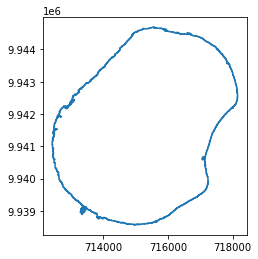

In [20]:
#cleanup
#os.remove(tin)
#os.remove(out)

coastline.to_file(aoi + "_shoreline_output.geojson", driver='GeoJSON')
coastline.plot()